In [75]:
import os
import sys
sys.path.append('../')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from authenticate_service_account import main
from utils import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import load_model
import SALib as sa
from SALib.sample import saltelli
from SALib.analyze import sobol
import shap


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
# """

# query_job = client.query(query)

# results = query_job.result()


In [3]:
# data = results.to_dataframe()


In [4]:
# data.to_csv('4Mrows.csv', index=False)


In [5]:
data = pd.read_csv('../raw_data/4Mrows.csv')


In [6]:
data.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
       'ItinLowe

# Start from scratch with data 

## Running preprocessor

In [7]:
processed_data = preprocess(data, ['OriginCty', 'DestinationCty'], as_ratio=True)
processed_data


,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,PricePerPax,ItineraryRedirects,ODRedirects,redirect_ratio,OD,total_travel_time,total_layover_time,total_layover_time_ratio,total_distance_traveled,extra_travel_distance_ratio
0,NaN,NaN,NaN,BEG,BEG,RS,24,NaN,False,1,...,591.8100,1,2,0.500000,NaN,575.0,95.0,0.141791,7265.0,NaN
1,NaN,NaN,NaN,BEG,BEG,RS,24,NaN,False,1,...,637.9000,1,2,0.500000,NaN,585.0,145.0,0.198630,7244.0,NaN
2,NaN,NaN,NaN,BEY,BEY,LB,23,NaN,False,0,...,180.1100,1,4,0.250000,NaN,115.0,0.0,0.000000,900.0,NaN
3,NaN,NaN,NaN,BEY,BEY,LB,23,NaN,False,0,...,181.1900,1,4,0.250000,NaN,110.0,0.0,0.000000,900.0,NaN
4,NaN,NaN,NaN,BEY,BEY,LB,23,NaN,False,0,...,187.1000,1,4,0.250000,NaN,145.0,0.0,0.000000,1239.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580499,ZUH,ZUH,CN,KMG,KMG,CN,5,1133.0,False,0,...,125.2675,4,5,0.800000,ZUHKMG,120.0,0.0,0.000000,1133.0,1.000000
2580500,ZUH,ZUH,CN,KOW,KOW,CN,21,461.0,False,0,...,52.1950,1,1,1.000000,ZUHKOW,80.0,0.0,0.000000,461.0,1.000000
2580501,ZYL,ZYL,BD,MAN,MAN,GB,7,8070.0,False,0,...,716.5630,5,5,1.000000,ZYLMAN,690.0,0.0,0.000000,8070.0,1.000000
2580502,ZYL,ZYL,BD,MAN,MAN,GB,17,8070.0,True,3,...,887.4400,1,3,0.333333,ZYLMAN,860.0,495.0,0.365314,9428.0,1.168278


### Checking the distribution of the redirect ratio


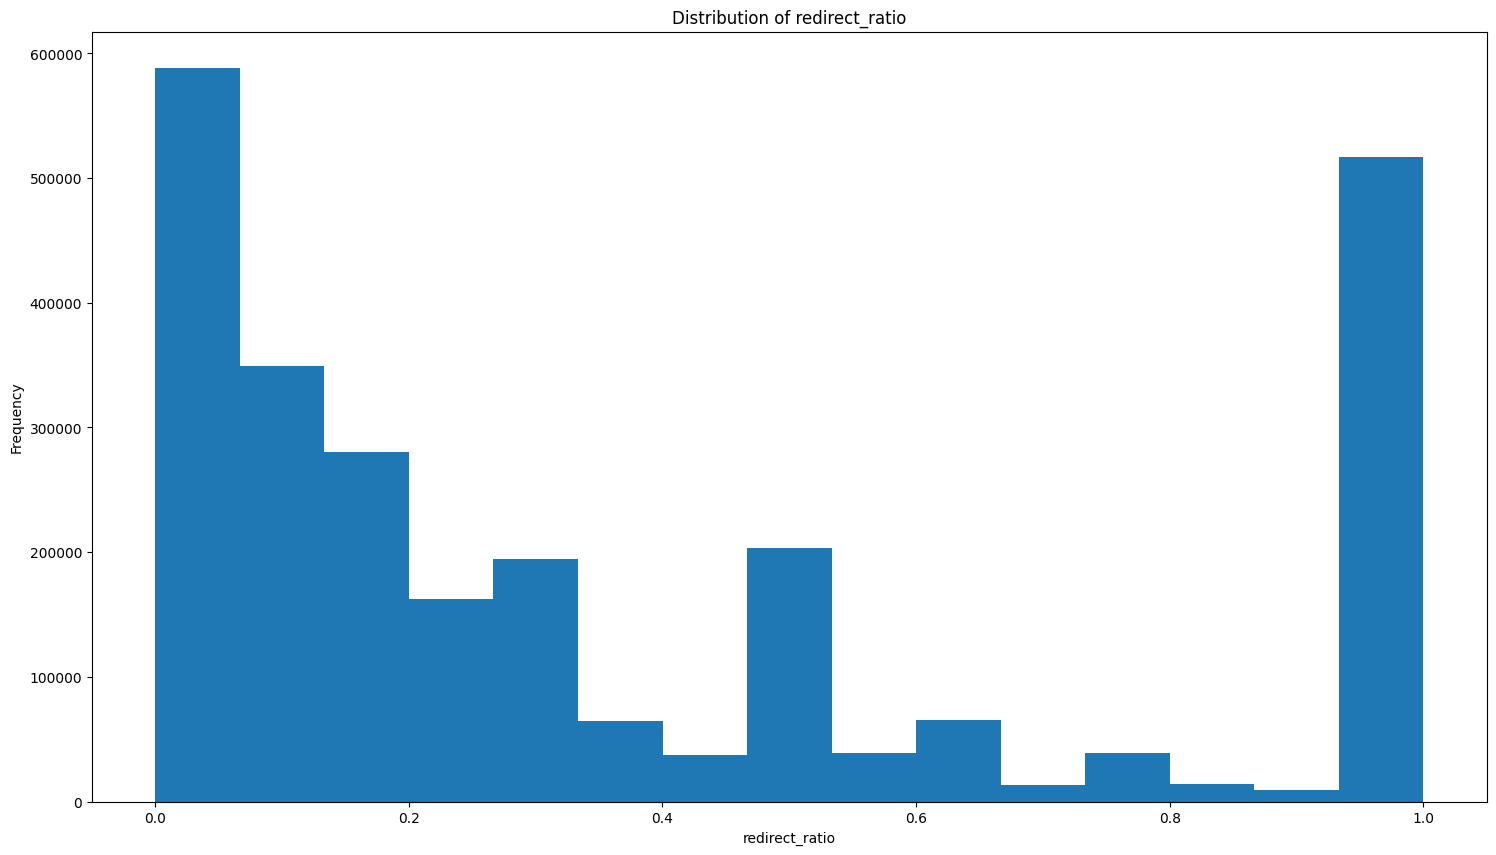

In [8]:
plt.figure(figsize=(18, 10))
plt.hist(processed_data["redirect_ratio"], bins=15)
plt.xlabel("redirect_ratio")
plt.ylabel("Frequency")
plt.title("Distribution of redirect_ratio")
plt.show()


In [9]:
df_grouped = processed_data.groupby(["OriginCty", "OriginApt"]).count()
df_grouped


,,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,DurationMin,Seg_0_OriginIATA,...,PricePerPax,ItineraryRedirects,ODRedirects,redirect_ratio,OD,total_travel_time,total_layover_time,total_layover_time_ratio,total_distance_traveled,extra_travel_distance_ratio
OriginCty,OriginApt,,,,,,,,,,,,,,,,,,,,,
AAE,AAE,150,147,147,147,150,147,150,150,150,150,...,150,150,150,150,147,150,150,150,150,147
AAL,AAL,427,426,426,426,427,426,427,427,427,427,...,427,427,427,427,426,427,427,427,427,426
AAN,AAN,45,44,44,44,45,44,45,45,45,45,...,45,45,45,45,44,45,45,45,45,44
AAR,AAR,338,337,337,337,338,337,338,338,338,338,...,338,338,338,338,337,338,338,338,338,337
AAT,AAT,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZVK,ZVK,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
ZXF,RVK,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
ZYI,WMT,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


## Testing the binary encoder

In [10]:
# import category_encoders as ce
# # Initialize BinaryEncoder
# binary_encoder = ce.BinaryEncoder(cols=["OD"])
# # Fit and transform the data
# binary_encoded_data = binary_encoder.fit_transform(processed_data)
# # Print the result
# print("Binary Encoded data:")
# print(binary_encoded_data.columns)


In [59]:
model_columns = ['ODRedirects', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'redirect_ratio', 'SelfTransfer',
                     'total_layover_time_ratio', 'extra_travel_distance_ratio']

model_data = processed_data[model_columns]


In [12]:
model_data.loc[:, "SelfTransfer"] = model_data["SelfTransfer"].astype(int)


In [13]:
model_data.head()


,ODRedirects,TravelDistanceKm,Stops,TravelHorizonDays,redirect_ratio,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio
0,2,NaN,1,24,0.50,0,0.141791,NaN
1,2,NaN,1,24,0.50,0,0.198630,NaN
2,4,NaN,0,23,0.25,0,0.000000,NaN
3,4,NaN,0,23,0.25,0,0.000000,NaN
4,4,NaN,0,23,0.25,0,0.000000,NaN


In [14]:
model_data.dtypes


ODRedirects                      int64
TravelDistanceKm               float64
Stops                            int64
TravelHorizonDays                int64
redirect_ratio                 float64
SelfTransfer                     int64
total_layover_time_ratio       float64
extra_travel_distance_ratio    float64
dtype: object

In [60]:
corr_matrix = model_data.corr()
corr_matrix


,ODRedirects,TravelDistanceKm,DurationMin,Stops,TravelHorizonDays,redirect_ratio,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio
ODRedirects,1.000000,-0.061354,-0.057542,-0.088128,-0.095570,-0.289898,-0.044685,-0.076697,-0.022173
TravelDistanceKm,-0.061354,1.000000,0.792637,0.550701,0.038800,0.054870,0.099576,0.239203,-0.018829
DurationMin,-0.057542,0.792637,1.000000,0.788496,-0.004707,0.078496,0.315487,0.655976,0.161641
Stops,-0.088128,0.550701,0.788496,1.000000,-0.038042,0.142416,0.445580,0.771914,0.244341
TravelHorizonDays,-0.095570,0.038800,-0.004707,-0.038042,1.000000,0.062637,-0.028231,-0.062875,-0.041313
redirect_ratio,-0.289898,0.054870,0.078496,0.142416,0.062637,1.000000,0.046109,0.131189,0.064473
SelfTransfer,-0.044685,0.099576,0.315487,0.445580,-0.028231,0.046109,1.000000,0.435233,0.157274
total_layover_time_ratio,-0.076697,0.239203,0.655976,0.771914,-0.062875,0.131189,0.435233,1.000000,0.272702
extra_travel_distance_ratio,-0.022173,-0.018829,0.161641,0.244341,-0.041313,0.064473,0.157274,0.272702,1.000000


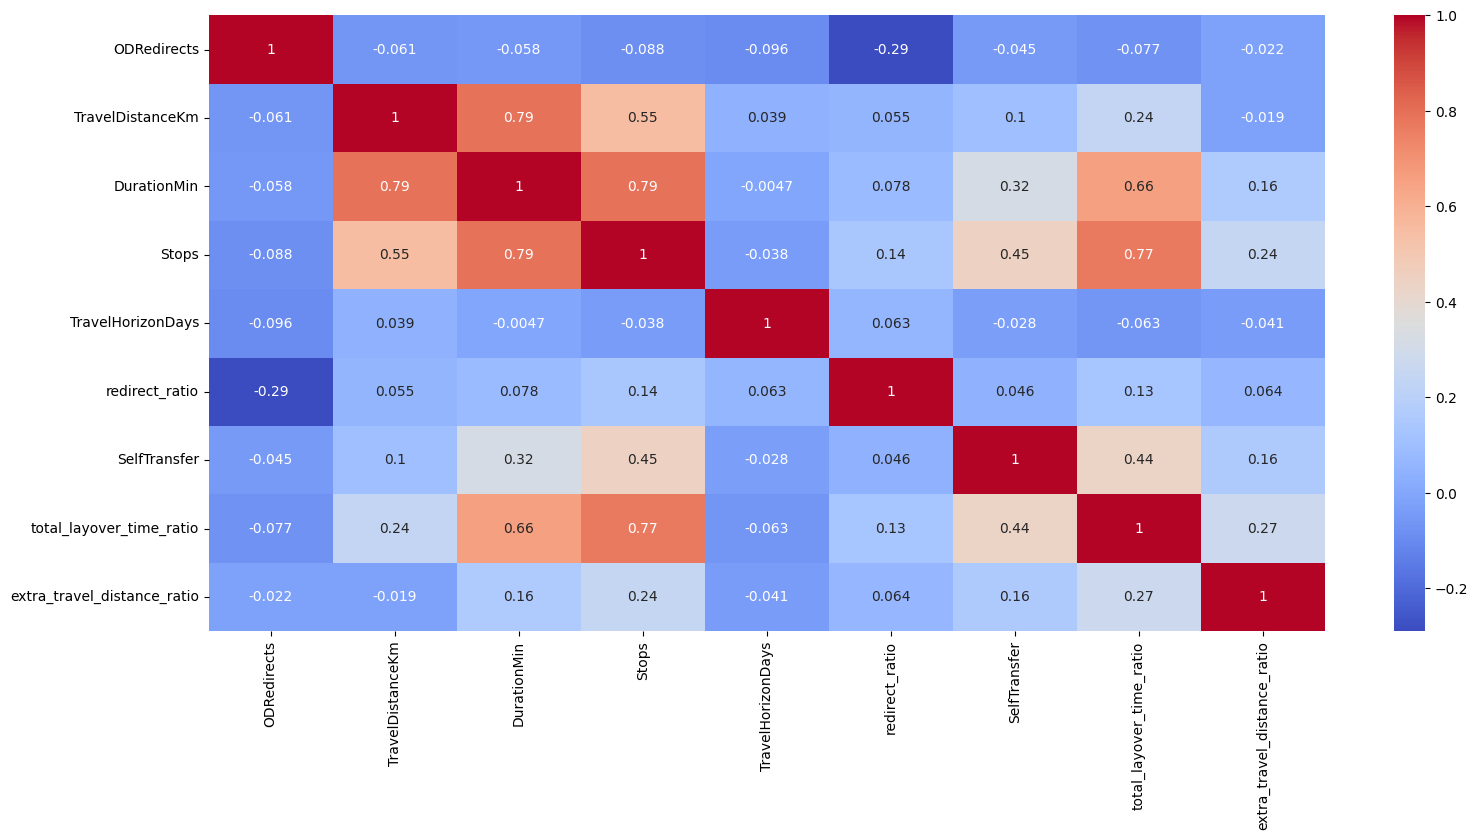

In [61]:
import seaborn as sns
plt.figure(figsize=(18,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


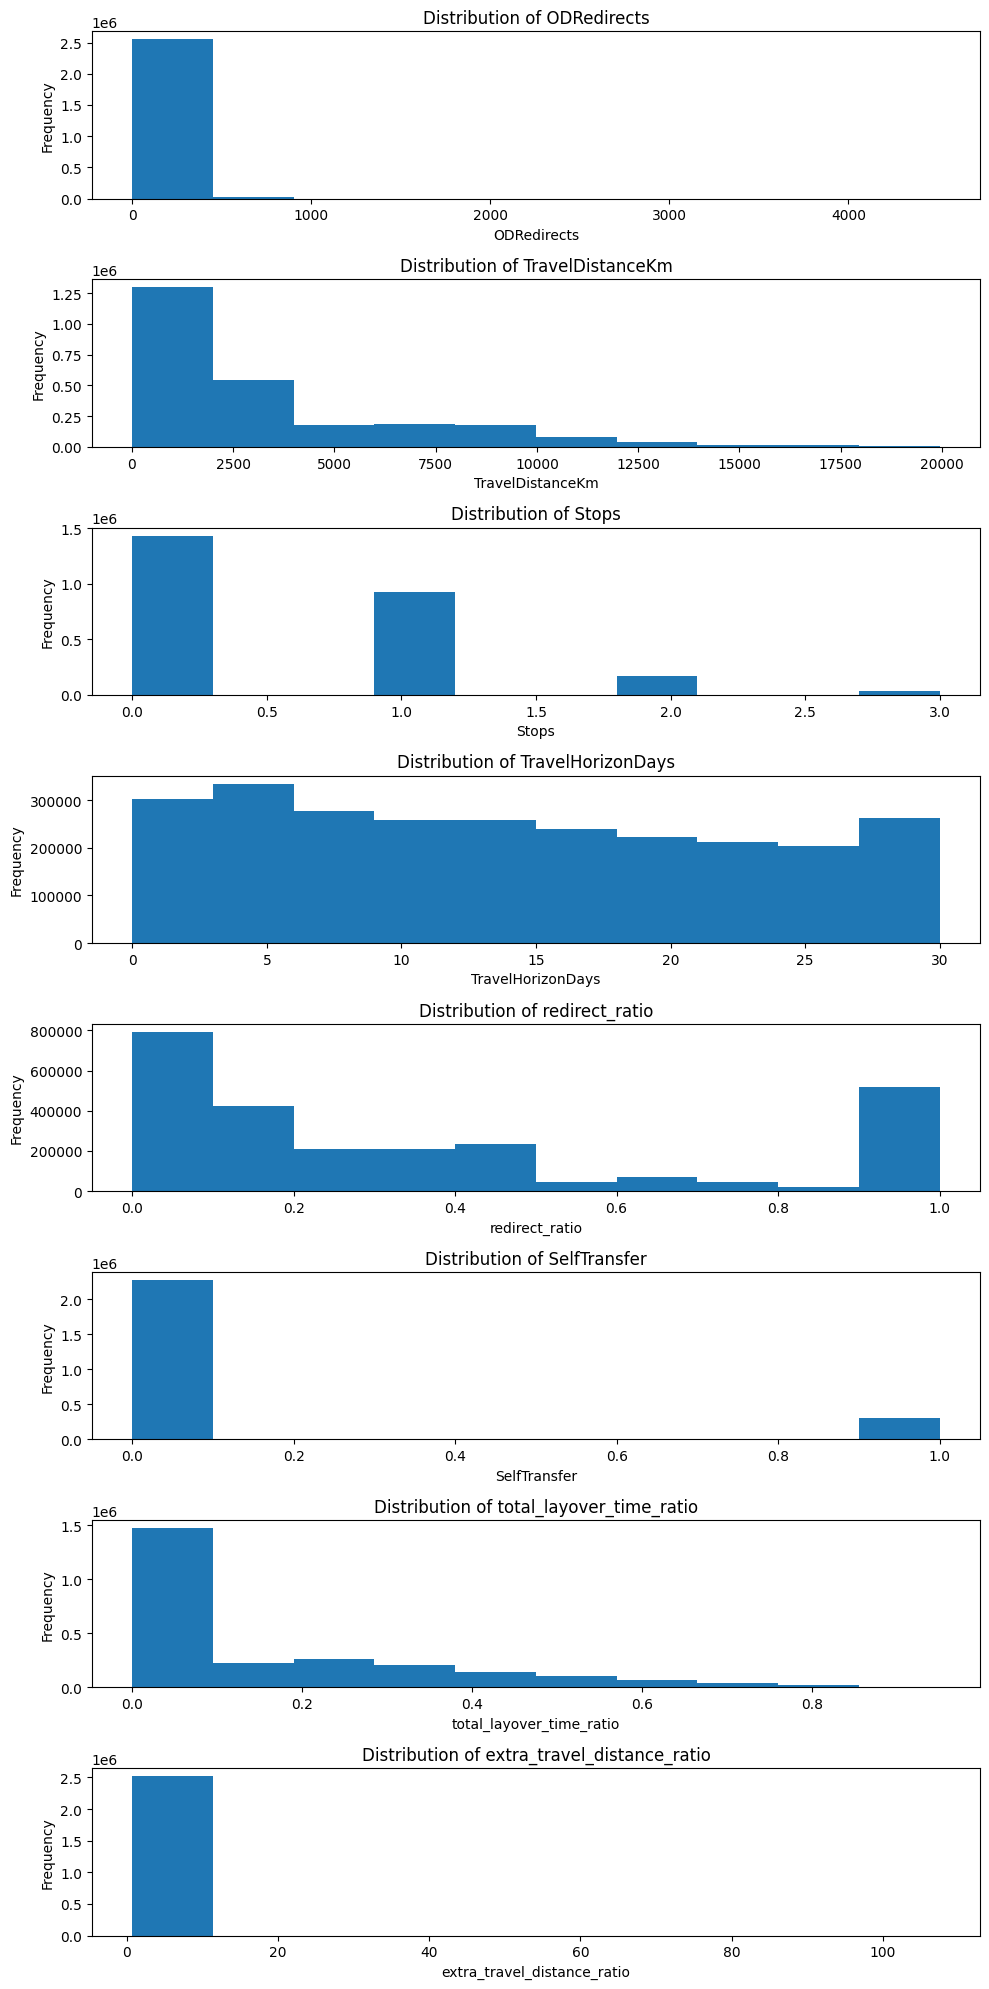

In [17]:
# Set a larger figure size for readability
plt.figure(figsize=(10, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist()
    plt.title(f'Distribution of {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Feature Engineering
- Log of ODRedirect
- Log of TravelDistanceKm
- Log of redirect_ratio
- Log of total_layover_time
- Log of extra_travel_distance

In [18]:
model_data.head()


,ODRedirects,TravelDistanceKm,Stops,TravelHorizonDays,redirect_ratio,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio
0,2,NaN,1,24,0.50,0,0.141791,NaN
1,2,NaN,1,24,0.50,0,0.198630,NaN
2,4,NaN,0,23,0.25,0,0.000000,NaN
3,4,NaN,0,23,0.25,0,0.000000,NaN
4,4,NaN,0,23,0.25,0,0.000000,NaN


In [19]:
model_data.dropna(inplace=True)


/var/folders/gn/wfrvz0691n11n_vt3c8dm4sr0000gn/T/ipykernel_12187/492987384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.dropna(inplace=True)


In [20]:
model_data.isna().any().any()


False

In [21]:
model_data.loc[:, 'ODRedirects'] = np.log1p(model_data['ODRedirects']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'TravelDistanceKm'] = np.log1p(model_data['TravelDistanceKm']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'redirect_ratio'] = np.log1p(model_data['redirect_ratio']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'total_layover_time_ratio'] = np.log1p(model_data['total_layover_time_ratio']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'extra_travel_distance_ratio'] = np.log1p(model_data['extra_travel_distance_ratio']+ 1e-9)  # 1e-9 is a small constant to offset zero values


### Apply MinMax Scalar

In [22]:
scaler = MinMaxScaler()


In [23]:
X_train, X_test, y_train, y_test = create_train_test_split(model_data, 'redirect_ratio')


In [26]:
Test_ODRedirect = X_test["ODRedirects"]
Test_ODRedirect


1010831    7.274480
2080131    1.609438
1283870    2.197225
828039     5.105945
1776132    0.693147
             ...   
2390812    2.484907
1623726    2.484907
1837108    2.484907
926195     1.609438
750779     3.850148
Name: ODRedirects, Length: 504217, dtype: float64

In [ ]:
Te


In [27]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [28]:
model = Sequential()
model.add(layers.Dense(64, input_dim=7, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


In [29]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)


In [31]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [32]:
# model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, callbacks=[early_stopping], validation_split=0.2)


In [33]:
#model.save('my_model.h5')


In [34]:
model = load_model('../models/my_model.h5')


In [35]:
# # Evaluate the model on the test set
# test_loss, test_error = model.evaluate(X_test, y_test, verbose=1)

# # Print the results
# print(f"Test Loss (MSE): {test_loss}")
# print(f"Test Error (MAE): {test_error}")


In [36]:
y_pred = model.predict(X_test)


15757/15757 [==============================] - 30s 2ms/step


In [37]:
X_test.shape


(504217, 7)

In [38]:
y_pred.shape


(504217, 1)

In [39]:
y_pred.dtype


dtype('float32')

In [40]:
y_test.shape


(504217,)

In [41]:
y_test.dtypes


dtype('float64')

In [42]:
y_diff = y_test - y_pred.flatten()


In [43]:
y_diff.shape


(504217,)

In [48]:
Test_ODRedirect


1010831    7.274480
2080131    1.609438
1283870    2.197225
828039     5.105945
1776132    0.693147
             ...   
2390812    2.484907
1623726    2.484907
1837108    2.484907
926195     1.609438
750779     3.850148
Name: ODRedirects, Length: 504217, dtype: float64

In [49]:
Test_ODRedirect = np.expm1(Test_ODRedirect)
Test_ODRedirect


1010831    1442.0
2080131       4.0
1283870       8.0
828039      164.0
1776132       1.0
            ...  
2390812      11.0
1623726      11.0
1837108      11.0
926195        4.0
750779       46.0
Name: ODRedirects, Length: 504217, dtype: float64

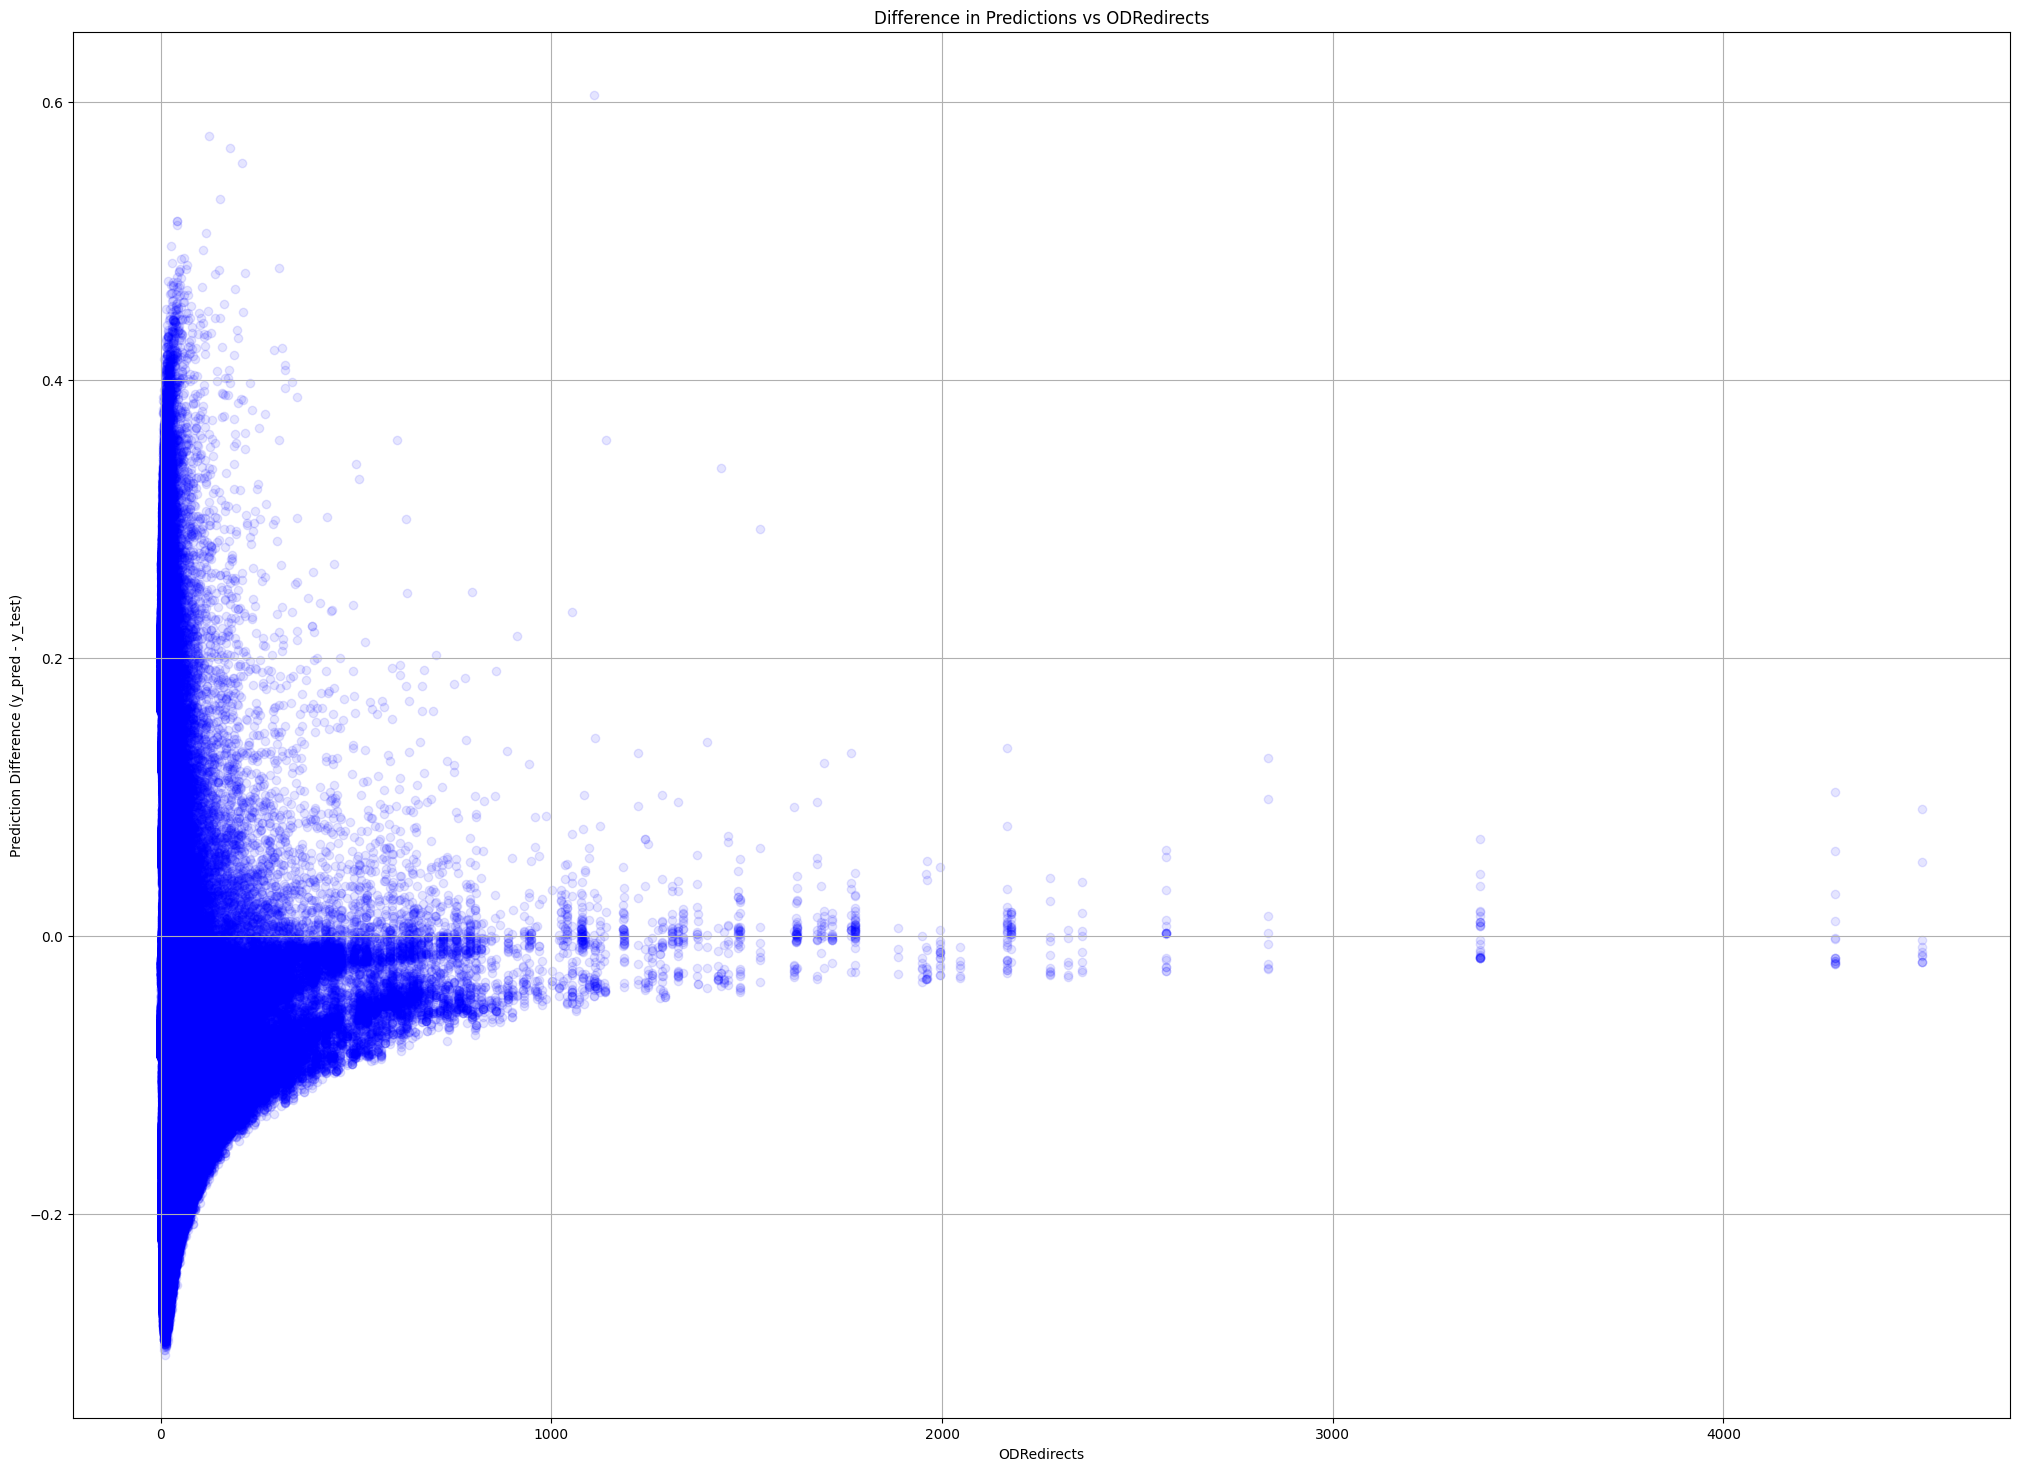

In [57]:
plt.figure(figsize=(25, 18))
plt.scatter(Test_ODRedirect, y_diff, color='blue', alpha=0.1)
plt.title('Difference in Predictions vs ODRedirects')
plt.xlabel('ODRedirects')
plt.ylabel('Prediction Difference (y_pred - y_test)')
plt.grid(True)


In [72]:
['ODRedirects', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'redirect_ratio', 'SelfTransfer',
                     'total_layover_time_ratio', 'extra_travel_distance_ratio']


# Define the model inputs
problem = {
    'num_vars': 7,
    'names': ['ODRedirects', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays', 'SelfTransfer', 'total_layover_time_ratio', 'extra_travel_distance_ratio'],  # Replace with your variables
    'bounds': [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]  # Replace with your variable bounds
}

# Generate samples
param_values = saltelli.sample(problem, 100)

# Run model
Y = np.array([model.predict(params.reshape(1, -1)) for params in param_values])

# Flatten Y if necessary
Y = Y.flatten()

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)

# Si contains the sensitivity indices


/var/folders/gn/wfrvz0691n11n_vt3c8dm4sr0000gn/T/ipykernel_12187/3467656381.py:14: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 100)
/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100) is equal to `2^n`.
        
  warnings.warn(msg)


1/1 [==============================] - 0s 26ms/step
                                   ST   ST_conf
ODRedirects                  1.012947  0.207275
TravelDistanceKm             0.001455  0.000905
Stops                        0.005662  0.002457
TravelHorizonDays            0.000210  0.000096
SelfTransfer                 0.002287  0.001361
total_layover_time_ratio     0.001296  0.000623
extra_travel_distance_ratio  0.000629  0.000259
                                   S1   S1_conf
ODRedirects                  1.031532  0.267990
TravelDistanceKm             0.004465  0.009307
Stops                        0.004803  0.015428
TravelHorizonDays            0.002317  0.003692
SelfTransfer                -0.005091  0.016687
total_layover_time_ratio    -0.003795  0.013535
extra_travel_distance_ratio  0.002722  0.006387
                                                          S2   S2_conf
(ODRedirects, TravelDistanceKm)                    -0.016867  0.304038
(ODRedirects, Stops)                  

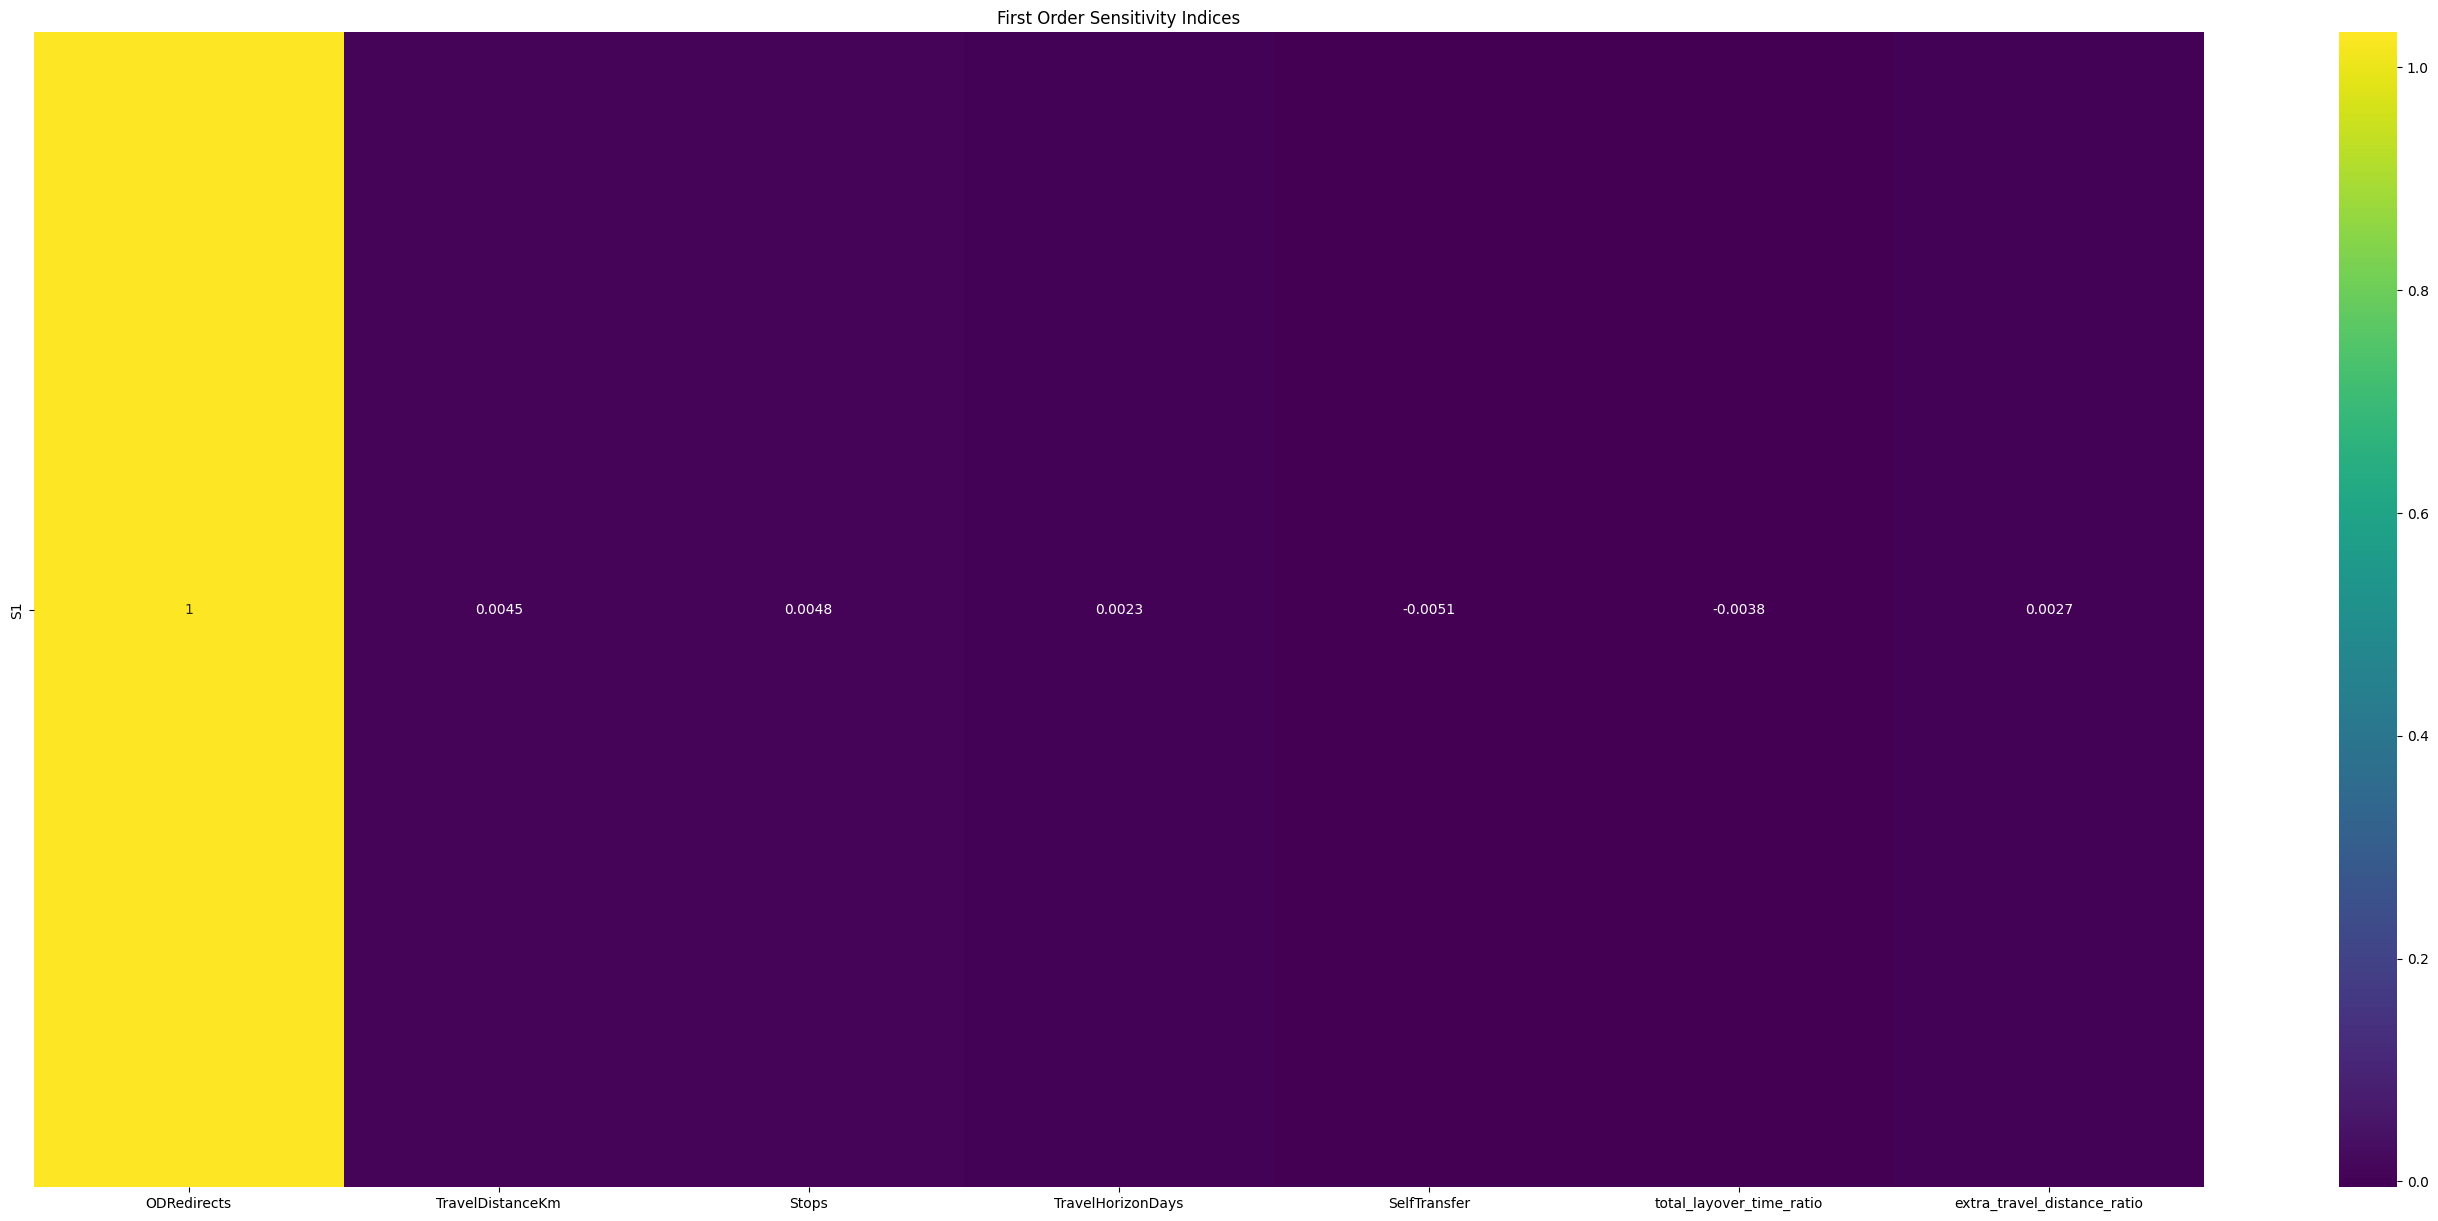

In [73]:
# Extracting the first order sensitivity indices
s1 = Si['S1']

# Creating a heatmap
plt.figure(figsize=(35, 15))
sns.heatmap([s1], annot=True, cmap='viridis', yticklabels=['S1'])
plt.title('First Order Sensitivity Indices')
plt.xticks(ticks=np.arange(len(s1)) + 0.5, labels=problem['names'])
plt.show()


In [77]:
# Create the explainer
explainer = shap.DeepExplainer(model, data=X_train)  # X_train is your training data

# Calculate SHAP values for a sample
shap_values = explainer.shap_values(X_test)  # X_test is your test data

# Plot the SHAP values
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:

# Assuming `model` is your trained model and `X_train` is your training data
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)  # X_test is your test data

# Calculate the mean absolute SHAP values for each feature
shap_sum = np.abs(shap_values[0]).mean(axis=0)

# Create a bar plot
plt.bar(range(len(shap_sum)), shap_sum)
plt.xlabel('Feature Index')
plt.ylabel('Mean Abs SHAP Value')
plt.title('Feature Importance')
plt.show()
